In [11]:
import torch
import networkx as nx
from torch.utils.data import Dataset, DataLoader
import numpy as np 
from sklearn.metrics import r2_score 
import time 
from matplotlib import pyplot as plt 
import copy
import pandas as pd 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelBinarizer
import seaborn as sbn 

import sys 
sys.path.append('../')

from src.models.GSNN import GSNN
from src.data.LincsDataset import LincsDataset
from src.models import utils 

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
#gsnn_drug_perf = np.load('../output/exp1-celldrug/GSNN1/f2a1e6fe-b206-4d8e-87b6-ac6499587593/r_drug_dict.pkl', allow_pickle=True)
#gsnn_drug_perf = np.load('../output/exp1-celldrug/GSNN2/1ebb1718-ae02-45ca-9440-7becdd64e922/r_drug_dict.pkl', allow_pickle=True)
gsnn_drug_perf = np.load('../output/exp1-celldrug/GSNN6/05ae84e8-961a-4c48-bdc4-0cb17219ab27/r_drug_dict.pkl', allow_pickle=True)
nn_drug_perf = np.load('../output/exp1-celldrug/NN1/cbbae0c5-c8a3-4e09-b08a-d660e44fc8cb/r_drug_dict.pkl', allow_pickle=True)

drug_df = pd.DataFrame(gsnn_drug_perf, index=[0]).T.reset_index().rename({'index': 'pert_id', 0:'gsnn_r'}, axis=1).merge(pd.DataFrame(nn_drug_perf, index=[0]).T.reset_index().rename({'index': 'pert_id', 0:'nn_r'}, axis=1))
drug_df.head()

,pert_id,gsnn_r,nn_r
0,BRD-K88510285,0.712375,0.760403
1,BRD-K00317371,0.187370,0.418082
2,BRD-K60219430,0.109988,0.138026
3,BRD-K90195324,0.604613,0.044453
4,BRD-K65924316,0.224155,0.413232


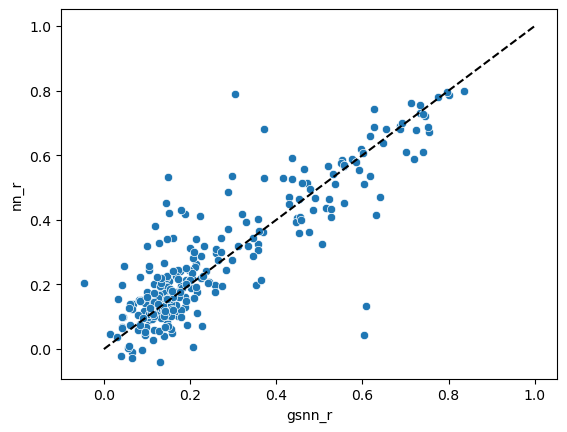

In [50]:
plt.figure()
sbn.scatterplot(x='gsnn_r', y='nn_r', data=drug_df)
plt.plot((0,1), (0,1), 'k--')
plt.show()

In [51]:
gsnn_gene_perf = np.load('../output/exp1-celldrug/GSNN6/05ae84e8-961a-4c48-bdc4-0cb17219ab27/r_gene_dict.pkl', allow_pickle=True)
nn_gene_perf = np.load('../output/exp1-celldrug/NN1/cbbae0c5-c8a3-4e09-b08a-d660e44fc8cb/r_gene_dict.pkl', allow_pickle=True)
#nn_gene_perf = np.load('../output/exp1-celldrug/GSNN1/1c016a28-519c-4094-9681-169c2f9c44bc/r_gene_dict.pkl', allow_pickle=True)

gene_df = pd.DataFrame(gsnn_gene_perf, index=[0]).T.reset_index().rename({'index': 'gene', 0:'gsnn_r'}, axis=1).merge(pd.DataFrame(nn_gene_perf, index=[0]).T.reset_index().rename({'index': 'gene', 0:'nn_r'}, axis=1))
gene_df.head()

,gene,gsnn_r,nn_r
0,O00180,0.452343,0.458791
1,O00206,0.270173,0.253660
2,O00214,0.405437,0.443780
3,O00233,0.419013,0.350808
4,O00273,0.529787,0.514594


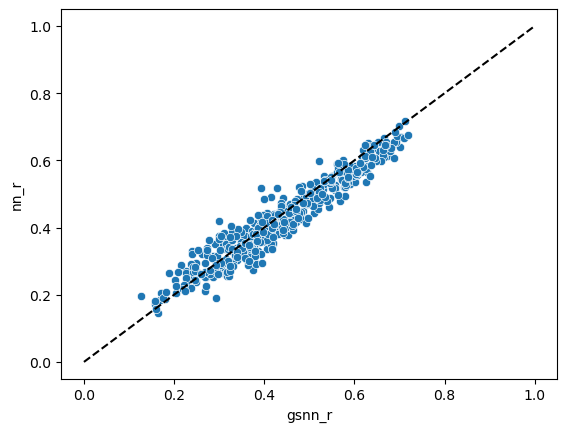

In [52]:
plt.figure()
sbn.scatterplot(x='gsnn_r', y='nn_r', data=gene_df)
plt.plot((0,1), (0,1), 'k--')
plt.show()

In [53]:
#gsnn_cell_perf = np.load('../output/exp1-celldrug/GSNN2/1ebb1718-ae02-45ca-9440-7becdd64e922/r_cell_dict.pkl', allow_pickle=True)
gsnn_cell_perf = np.load('../output/exp1-celldrug/GSNN6/05ae84e8-961a-4c48-bdc4-0cb17219ab27/r_cell_dict.pkl', allow_pickle=True)
nn_cell_perf = np.load('../output/exp1-celldrug/NN1/cbbae0c5-c8a3-4e09-b08a-d660e44fc8cb//r_cell_dict.pkl', allow_pickle=True)
#nn_cell_perf = np.load('../output/exp1-celldrug/GSNN1/1c016a28-519c-4094-9681-169c2f9c44bc/r_cell_dict.pkl', allow_pickle=True)

cell_df = pd.DataFrame(gsnn_cell_perf, index=[0]).T.reset_index().rename({'index': 'cell_iname', 0:'gsnn_r'}, axis=1).merge(pd.DataFrame(nn_cell_perf, index=[0]).T.reset_index().rename({'index': 'cell_iname', 0:'nn_r'}, axis=1))
cell_df.head()

,cell_iname,gsnn_r,nn_r
0,NCIH1437,0.651010,0.660821
1,VCAP,0.698553,0.700004
2,YAPC,0.446110,0.447354
3,SKES1,0.247362,0.316036
4,SH4,0.212220,0.368381


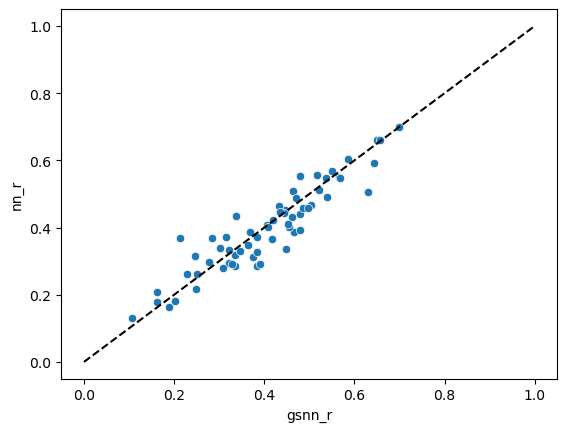

In [54]:
plt.figure()
sbn.scatterplot(x='gsnn_r', y='nn_r', data=cell_df)
plt.plot((0,1), (0,1), 'k--')
plt.show()

In [2]:
siginfo = pd.read_csv('../../data/siginfo_beta.txt', sep='\t', low_memory=False)
siginfo.head()

,bead_batch,nearest_dose,pert_dose,pert_dose_unit,pert_idose,pert_itime,pert_time,pert_time_unit,cell_mfc_name,pert_mfc_id,...,cell_iname,det_wells,det_plates,distil_ids,build_name,project_code,cmap_name,is_exemplar_sig,is_ncs_sig,is_null_sig
0,b17,NaN,100.0,ug/ml,100 ug/ml,336 h,336.0,h,N8,BRD-U44432129,...,NAMEC8,H05|H06|H07|H08,MET001_N8_XH_X1_B17,MET001_N8_XH_X1_B17:H05|MET001_N8_XH_X1_B17:H0...,NaN,MET,BRD-U44432129,0,0.0,0.0
1,b15,10.0,10.0,uM,10 uM,3 h,3.0,h,A549,BRD-K81418486,...,A549,L04|L08|L12,ABY001_A549_XH_X1_B15,ABY001_A549_XH_X1_B15:L04|ABY001_A549_XH_X1_B1...,NaN,ABY,vorinostat,0,1.0,0.0
2,b15,2.5,2.5,uM,2.5 uM,24 h,24.0,h,HT29,BRD-K70511574,...,HT29,E18|E22,ABY001_HT29_XH_X1_B15,ABY001_HT29_XH_X1_B15:E18|ABY001_HT29_XH_X1_B1...,NaN,ABY,HMN-214,0,1.0,0.0
3,b18,10.0,10.0,uM,10 uM,3 h,3.0,h,HME1,BRD-K81418486,...,HME1,F19,LTC002_HME1_3H_X1_B18,LTC002_HME1_3H_X1_B18:F19,NaN,LTC,vorinostat,0,0.0,0.0
4,b15,10.0,10.0,uM,10 uM,3 h,3.0,h,H1975,BRD-A61304759,...,H1975,P01|P05|P09,ABY001_H1975_XH_X1_B15,ABY001_H1975_XH_X1_B15:P01|ABY001_H1975_XH_X1_...,NaN,ABY,tanespimycin,0,0.0,0.0


In [5]:
siginfo[lambda x: x.pert_type == 'trt_cp'].groupby('pert_time').count()[['bead_batch']].sort_values(by='bead_batch', ascending=False)

,bead_batch
pert_time,
24.0,559163
6.0,138006
3.0,11998
4.0,4704
48.0,4372
72.0,796
12.0,360
-666.0,230
2.0,188


In [6]:
138006 / (138006 + 559163)

0.19795200302939459

In [76]:
cellinfo = pd.read_csv('../../data/' + '/cellinfo_beta.txt', sep='\t', low_memory=False)
cellinfo.head()

,cell_iname,cellosaurus_id,donor_age,donor_age_death,donor_disease_age_onset,doubling_time,growth_medium,provider_catalog_id,feature_id,cell_type,donor_ethnicity,donor_sex,donor_tumor_phase,cell_lineage,primary_disease,subtype,provider_name,growth_pattern,ccle_name,cell_alias
0,1HAE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,normal,Unknown,Unknown,Unknown,unknown,unknown,normal fibroblast sample,NaN,unknown,NaN,NaN
1,AALE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,normal,Unknown,Unknown,Unknown,unknown,unknown,normal epithelium sample,NaN,unknown,NaN,NaN
2,AG06263_2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tumor,Unknown,Unknown,Unknown,unknown,unknown,unknown,NaN,unknown,NaN,NaN
3,AG06840_A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tumor,Unknown,Unknown,Unknown,unknown,unknown,unknown,NaN,unknown,NaN,NaN
4,AG078N1_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,tumor,Unknown,Unknown,Unknown,unknown,unknown,unknown,NaN,unknown,NaN,NaN


In [131]:

def split_ids_by_attribute(ids, attributes, proportions):
    '''
    1. group `ids` by `attribute` 
    2. order by size of attribute (# ids in attribute)
    3. randomly select an id from each attribute group for each split until the right proportions are reached. 
    
    This ensures that the largest attributes will be equally represented in each split but also ensures for id splits. 
    NOTE: If there are more attribute groups than a given split size, then the smaller attirbute groups will not be represented. 

    Args: 
        ids             listlike            ids to split; len N 
        attributes      listlike            respective id attributes; len N 
        proportions     listlike            number of splits and proportions to assign to each split; 
                                            the first split group proportion may not perfectly match due to integer rounding/casting errors.
                                            len S

    Returns: 
        splits          list of lists       groups of ids assigned to each split; len S 
    ''' 
    assert np.isclose(sum(proportions), 1), 'proportions do not sum to 1'
    ids = list(ids)
    attributes = np.array(attributes)
    _ids = np.sort(ids)
    attrs, cnts = np.unique(attributes, return_counts=True)
    attrs = attrs[np.argsort(cnts)]      # ensure that the attribute groups are sorted by number of ids in each attribute. 
    grouped_ids = [np.array(ids)[attributes == a].tolist() for a in attrs]   # cell lines grouped by attribute in sorted order; same order as attr 

    n = len(ids)
    split_sizes = [np.round(p*n) for p in proportions[1:]]
    split_sizes = [n - sum(split_sizes)] + split_sizes 
    split_sizes = [int(x) for x in split_sizes]

    splits = [[] for i in proportions]

    while len(ids) > 0: 
        for group in grouped_ids: 
            for split, size in zip(splits, split_sizes): 
                if (len(split) < size) & (len(ids) > 0) & (len(group) > 0): 
                    np.random.shuffle(group)
                    id = group.pop()
                    split.append(id) 
                    ids.remove(id)
                    
    assert sum([len(x) for x in splits]) == n, 'union of splits are a different size than original id list'

    test = [] 
    for s in splits: 
        test+=s 
    assert (np.sort(test) == _ids).all(), 'splits are not unique or are missing ids'

    return splits



# Sample data
ids = [str(x) for x in list(range(50))]
attributes = np.random.choice([str(x) for x in range(100)], size=50).tolist()
proportions = [0.6, 0.3, 0.1]
print(sum(proportions))

groups = split_ids_by_attribute(ids, attributes, proportions)
print(groups)
prop_attr1 = np.unique(np.array(attributes)[groups[0]], return_counts=True)[1]
print(prop_attr1)
prop_attr1 = prop_attr1/sum(prop_attr1)
print(prop_attr1)
prop_attr2 = np.unique(np.array(attributes)[groups[1]], return_counts=True)[1]
print(prop_attr2)
prop_attr2 = prop_attr2/sum(prop_attr2)
print(prop_attr2)
prop_attr3 = np.unique(np.array(attributes)[groups[2]], return_counts=True)[1]
print(prop_attr3)
prop_attr3 = prop_attr3/sum(prop_attr3)
print(prop_attr3)

0.9999999999999999
[['43', '17', '4', '11', '37', '25', '14', '33', '34', '30', '49', '29', '9', '10', '3', '23', '27', '18', '22', '12', '45', '40', '28', '5', '41', '16', '46', '15', '44', '21'], ['8', '24', '7', '32', '1', '2', '42', '0', '13', '35', '48', '47', '31', '38', '20'], ['36', '39', '26', '19', '6']]


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [129]:
attributes

array(['43', '47', '80', '67', '93', '44', '2', '12', '81', '22', '68',
       '67', '63', '75', '63', '6', '17', '87', '91', '16', '74', '62',
       '82', '93', '68', '10', '54', '27', '0', '20', '22', '20', '28',
       '47', '98', '29', '91', '71', '46', '51', '21', '85', '94', '37',
       '34', '5', '50', '94', '65', '85'], dtype='<U2')

In [125]:
g1, g2, g3 = split_ids_by_attribute(ids, attributes, proportions)
g1

[12,
 47,
 29,
 42,
 34,
 5,
 9,
 16,
 13,
 43,
 19,
 3,
 49,
 21,
 48,
 35,
 45,
 27,
 25,
 14,
 39,
 24,
 6,
 31,
 46,
 18,
 2,
 10,
 36,
 32]

In [66]:
groups = split_ids_by_attribute(ids, attributes, proportions)
print(groups)
print(np.array(attributes)[groups[0]])
print(np.array(attributes)[groups[1]])
print(np.array(attributes)[groups[2]])

[[4, 8, 5, 0, 7], [2, 6], [1, 3]]
['A' 'B' 'C' 'A' 'A']
['A' 'B']
['A' 'B']


In [7]:
len(ids)*0.2

1.8

In [5]:
for i in range(torch.cuda.device_count()): print(f'cuda device {i}: {torch.cuda.get_device_properties(i).name}')

cuda device 0: NVIDIA GeForce RTX 3090


In [2]:
root = '../output/exp1-allomics/'

data = torch.load(f'{root}/proc/Data.pt')

train_ids = np.load(f'{root}/proc/train_obs.npy', allow_pickle=True)
train_dataset = LincsDataset(root='./processed_data/', sig_ids=train_ids)
train_loader = DataLoader(train_dataset, batch_size=10, num_workers=12, shuffle=True)

test_ids = np.load(f'{root}proc//test_obs.npy', allow_pickle=True)
test_dataset = LincsDataset(root=f'{root}/proc/', sig_ids=test_ids)
test_loader = DataLoader(test_dataset, batch_size=100, num_workers=4, shuffle=True)

FileNotFoundError: [Errno 2] No such file or directory: '../output/exp1-allomics//proc/Data.pt'

In [ ]:
siginfo = pd.read_csv('../../data/siginfo_beta.txt', sep='\t', low_memory=False)

In [ ]:
model = torch.load(f'{root}/f9d68b65-82a3-41b9-acbf-47f62060295f/model.pt')
y, yhat, sig_ids = utils.predict_gsnn(test_loader, model, data, device='cuda')
r_cell = utils.get_regressed_r(y, yhat, sig_ids, vars=['pert_id', 'pert_dose'], multioutput='raw_values', siginfo=siginfo)
r_drug = utils.get_regressed_r(y, yhat, sig_ids, vars=['cell_iname', 'pert_dose'], multioutput='raw_values', siginfo=siginfo)
r_dose = utils.get_regressed_r(y, yhat, sig_ids, vars=['pert_id', 'cell_iname'], multioutput='raw_values', siginfo=siginfo)
print('r cell', np.mean(r_cell))
print('r drug', np.mean(r_drug))
print('r dose', np.mean(r_dose))


r cell 0.07509303801710582
r drug 0.32581307129196696
r dose 0.1994910882863461


In [ ]:
model_cell_agnostic = torch.load(f'{root}/92e3df89-4bf1-4450-ae11-1c01ca91be2b/model.pt')
data_cell_agnostic = torch.load(f'{root}/92e3df89-4bf1-4450-ae11-1c01ca91be2b/Data.pt')
y2, yhat2, sig_ids2 = utils.predict_nn(test_loader, model_cell_agnostic, data_cell_agnostic, device='cuda')
r_cell2 = utils.get_regressed_r(y2, yhat2, sig_ids2, vars=['pert_id', 'pert_dose'], multioutput='raw_values', siginfo=siginfo)
r_drug2 = utils.get_regressed_r(y2, yhat2, sig_ids2, vars=['cell_iname', 'pert_dose'], multioutput='raw_values', siginfo=siginfo)
r_dose2 = utils.get_regressed_r(y2, yhat2, sig_ids2, vars=['pert_id', 'cell_iname'], multioutput='raw_values', siginfo=siginfo)
print('r cell', np.mean(r_cell2))
print('r drug', np.mean(r_drug2))
print('r dose', np.mean(r_dose2))

r cell 0.001262534544927378
r drug 0.3753426458700532
r dose 0.25080154063987203


In [94]:
model2 = torch.load(f'{root}/531c7bb1-0e85-4846-b628-fc71f7e680d7/model.pt')
data2 = torch.load(f'{root}/531c7bb1-0e85-4846-b628-fc71f7e680d7/Data.pt')
y3, yhat3, sig_ids3 = utils.predict_nn(test_loader, model2, data2, device='cuda')
r_cell3 = utils.get_regressed_r(y3, yhat3, sig_ids3, vars=['pert_id', 'pert_dose'], multioutput='raw_values', siginfo=siginfo)
r_drug3 = utils.get_regressed_r(y3, yhat3, sig_ids3, vars=['cell_iname', 'pert_dose'], multioutput='raw_values', siginfo=siginfo)
r_dose3 = utils.get_regressed_r(y3, yhat3, sig_ids3, vars=['pert_id', 'cell_iname'], multioutput='raw_values', siginfo=siginfo)
print('r cell', np.mean(r_cell3))
print('r drug', np.mean(r_drug3))
print('r dose', np.mean(r_dose3))

r cell 0.010380177582964747
r drug 0.32643106334308014
r dose 0.204048028689484


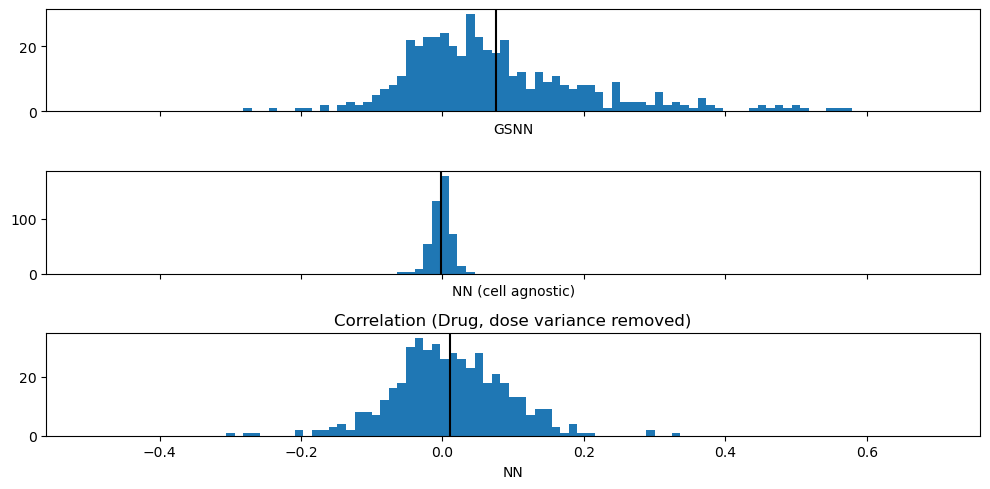

In [89]:
f,axes = plt.subplots(3,1, figsize=(10,5), sharex=True)
plt.title('Correlation (Drug, dose variance removed)')
axes[0].hist(r_cell, bins=np.linspace(-0.5, 0.7, 100))
axes[0].set_xlabel('GSNN')
axes[0].axvline(np.mean(r_cell), c='k')
axes[1].hist(r_cell2, bins=np.linspace(-0.5, 0.7, 100))
axes[1].axvline(np.mean(r_cell2), c='k')
axes[1].set_xlabel('NN (cell agnostic)')
axes[2].hist(r_cell3, bins=np.linspace(-0.5, 0.7, 100))
axes[2].axvline(np.mean(r_cell3), c='k')
axes[2].set_xlabel('NN')
plt.tight_layout()
plt.show()

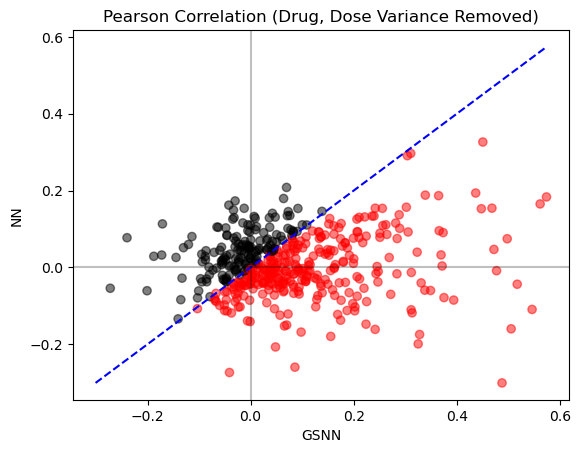

In [87]:
_min = min(min(r_cell), min(r_cell3))
_max = max(max(r_cell), max(r_cell3))

c = ['r' if a > b else 'k' for a,b in zip(r_cell, r_cell3)]

plt.figure()
plt.title('Pearson Correlation (Drug, Dose Variance Removed)')
plt.scatter(r_cell, r_cell3, c=c, alpha=0.5)
plt.plot((_min, _max), (_min, _max), 'b--')
plt.axvline(0, c='k', alpha=0.25)
plt.axhline(0, c='k', alpha=0.25)
plt.xlabel('GSNN')
plt.ylabel('NN')
plt.show()

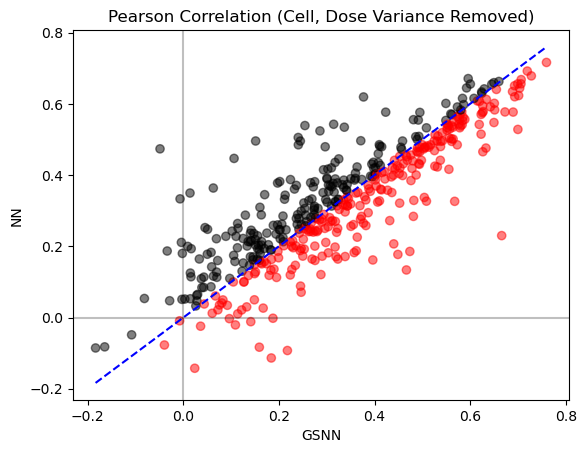

In [97]:
_min = min(min(r_drug), min(r_drug3))
_max = max(max(r_drug), max(r_drug3))

c = ['r' if a > b else 'k' for a,b in zip(r_drug, r_drug3)]

plt.figure()
plt.title('Pearson Correlation (Cell, Dose Variance Removed)')
plt.scatter(r_drug, r_drug3, c=c, alpha=0.5)
plt.plot((_min, _max), (_min, _max), 'b--')
plt.axvline(0, c='k', alpha=0.25)
plt.axhline(0, c='k', alpha=0.25)
plt.xlabel('GSNN')
plt.ylabel('NN')
plt.show()

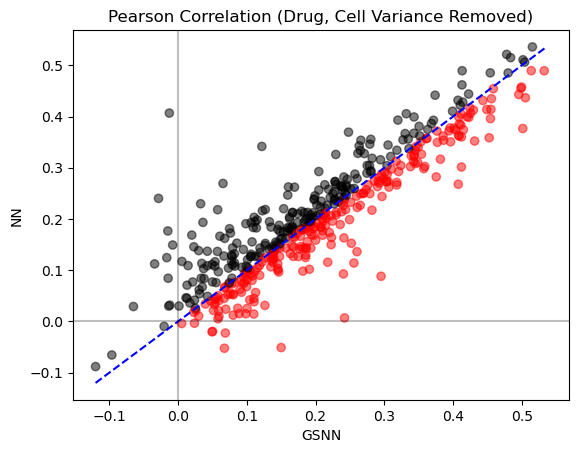

In [99]:
_min = min(min(r_dose), min(r_dose3))
_max = max(max(r_dose), max(r_dose3))

c = ['r' if a > b else 'k' for a,b in zip(r_dose, r_dose3)]

plt.figure()
plt.title('Pearson Correlation (Drug, Cell Variance Removed)')
plt.scatter(r_dose, r_dose3, c=c, alpha=0.5)
plt.plot((_min, _max), (_min, _max), 'b--')
plt.axvline(0, c='k', alpha=0.25)
plt.axhline(0, c='k', alpha=0.25)
plt.xlabel('GSNN')
plt.ylabel('NN')
plt.show()